In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import uuid
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

In [2]:
cwd = os.getcwd()

In [3]:
print(cwd)

C:\Users\AmitKumar\Downloads\final-project-code-kumaramit41-main\final-project-code-kumaramit41-main


In [4]:
#!unzip data.zip

In [5]:
POS_PATH ='data_crop/positive_crop'
NEG_PATH ='data_crop/negative_crop'
ANC_PATH ='data_crop/anchor_crop'

# Loading and Processing Image

In [6]:
# Get Image directory
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg')
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg')
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg')

In [7]:
# Sacle and Resize
def preprocess_img(file_path):
    
    # Read in image from file path
    b_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(b_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (224,224))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

# Creating Labels

In [8]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [9]:
samples = data.as_numpy_iterator()

In [10]:
exmp = samples.next()
print(exmp)

(b'data_crop\\anchor_crop\\RE1135.jpg', b'data_crop\\positive_crop\\RE202.jpg', 1.0)


# Train and Test Partiton

In [11]:
def preprocess_twin_img(input_img, validation_img, label):
    return(preprocess_img(input_img), preprocess_img(validation_img), label)

1.0


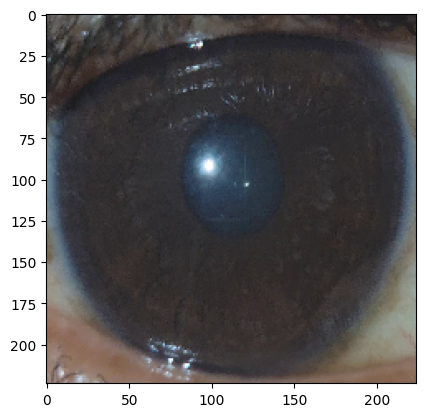

In [12]:
res = preprocess_twin_img(*exmp)
plt.imshow(res[1])
print(res[2])

In [13]:
# Build dataloader pipeline
data = data.map(preprocess_twin_img)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [14]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [15]:
#Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8) 

# Model Engineering

## Embedding Model

In [16]:
def form_embedding_vgg19():
    #vgg19 architecture
    inputlayer = Input(shape=(224,224,3), name='input_layer')
    m1 = tf.keras.applications.VGG19(include_top=True,
                                        weights=None,
                                        input_tensor=None,
                                        input_shape= None ,
                                        pooling=None,
                                        #classes=2,
                                        classifier_activation='sigmoid',
                                        )(inputlayer)

    return Model(inputs=[inputlayer],outputs = [m1],name='VGG19')

In [17]:
# VGG19 embedding
embedding_vgg19 = form_embedding_vgg19()

## distance Layer

In [18]:
# Siamese L1 Distance class
class L1_Distance(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## Siamese network

In [19]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(224,224,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(224,224,3))
    
    # Combine siamese distance components
    siamese_layer = L1_Distance()
    siamese_layer._name = 'distance'
    #distances = siamese_layer(embedding_efB4(input_image), embedding_efB4(validation_image))
    distances = siamese_layer(embedding_vgg19(input_image), embedding_vgg19(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [20]:
siamese_model = make_siamese_model()

In [21]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG19 (Functional)             (None, 1000)         143667240   ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

In [108]:
# Loss and Optimier
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [109]:
# establish checkpoint
checkpoint_dir = './training_checkpoints_vgg19'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [110]:
# Train Step Function
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [111]:
# Training Loop
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## Train The model

In [112]:
EPOCHS = 50

In [113]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
45/45 [==============================] - 15s 99ms/step
0.06932393 0.95543176 0.8932292

 Epoch 2/50
45/45 [==============================] - 4s 87ms/step
0.018298179 0.9942693 0.988604

 Epoch 3/50
45/45 [==============================] - 4s 90ms/step
0.95087254 1.0 0.99717516

 Epoch 4/50
45/45 [==============================] - 4s 87ms/step
0.69171345 0.56980056 0.9174312

 Epoch 5/50
45/45 [==============================] - 4s 87ms/step
0.68767995 0.5426136 0.59874606

 Epoch 6/50
45/45 [==============================] - 4s 87ms/step
0.69874144 0.8523677 0.5645757

 Epoch 7/50
45/45 [==============================] - 4s 86ms/step
0.7059964 0.8910614 0.5576923

 Epoch 8/50
45/45 [==============================] - 4s 86ms/step
0.69252926 0.8362069 0.5408922

 Epoch 9/50
45/45 [==============================] - 4s 87ms/st

## Evaluating Model

In [114]:
# Batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])

In [115]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]
print(y_true)

[0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0.]


## Comparision Matrix 

In [116]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [117]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

0.98039216 0.6849315


# Result

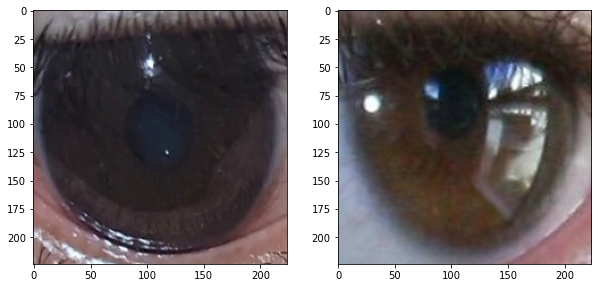

In [118]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[7])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[7])

# Renders cleanly
plt.show()

# Save Model

In [79]:
#Save model weights
siamese_model.save('siamesemodelv2Vgg19.h5')

In [81]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2Vgg19.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [82]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[9.9975890e-01],
       [2.7097631e-04],
       [3.2596089e-04],
       [9.9987459e-01],
       [9.9947733e-01],
       [9.9996161e-01],
       [2.6847055e-04],
       [1.8092419e-04],
       [1.7680328e-04],
       [9.9974853e-01],
       [1.9379104e-04],
       [9.9991822e-01],
       [9.9984157e-01],
       [2.2362116e-04]], dtype=float32)